# Solving AOC 19 with optimization

Day 19 of this year's Advent of Code is a nice geometrical problem. We are given sets of points detected by different scanners in $3d$ space. Each scanner has its own coordinate system and does **not** know its own position with respect to the others. Based on some common detected points that scanners share, the task is to retrieve their relative relative positions in a single coordinate system. A longer and more accurate description can be found at https://adventofcode.com/2021/day/19.

This task can be split into several smaller steps:

- identify the scanners which share common points
- choose a reference coordinate system
- determine the transformation needed to translate all the sets of points into the chosen coordinate system

In this post, I'm going to talk about how I solved this problem using some algorithms from convex optimization :)  

## Reading the input data

First, we should read and analyze the data to know what we're dealing with. I saved the example data which is given in the problem description in a text file, which can be easily parsed as done below

In [1]:
import numpy as np


def read_input(text_file):
    scanners = list()
    with open(text_file) as f:
        for line in f:
            if "scanner" in line:
                scanners.append(list())
            elif len(line.strip()) == 0:
                scanners[-1] = np.array(scanners[-1])
            else:
                scanners[-1].append(tuple(int(i) for i in line.strip().split(",")))
    scanners[-1] = np.array(scanners[-1])
    return scanners


points = read_input("test.txt")

We can also take a look at the some of the points detected by the scanners

In [2]:
points[0]

array([[ 404, -588, -901],
       [ 528, -643,  409],
       [-838,  591,  734],
       [ 390, -675, -793],
       [-537, -823, -458],
       [-485, -357,  347],
       [-345, -311,  381],
       [-661, -816, -575],
       [-876,  649,  763],
       [-618, -824, -621],
       [ 553,  345, -567],
       [ 474,  580,  667],
       [-447, -329,  318],
       [-584,  868, -557],
       [ 544, -627, -890],
       [ 564,  392, -477],
       [ 455,  729,  728],
       [-892,  524,  684],
       [-689,  845, -530],
       [ 423, -701,  434],
       [   7,  -33,  -71],
       [ 630,  319, -379],
       [ 443,  580,  662],
       [-789,  900, -551],
       [ 459, -707,  401]])

## Find the relations between different sets

Once we read the data, we should find the sets which share at least 12 points, as stated in the problem description. To do so, we can compute the pairwise distances among all points in the same set (according to some norm). Then, if two sets share at least 66 such distances, it means there are at least 12 points in common between them (since the number of pairwise distances between 12 points is 66, i.e., 12 choose 2). We call sets which share at least 12 points a "couple". Note that I'm using python sets, which could give wrong results. Indeed, if more than 2 points are at the same distance (for example (0,0,0), (1,1,1), (2,2,2)), only one distance would be counted, and we would potentially miss some related sets (if this causes the shared distances to be less than 66). Neverthless, this is easy to fix, altough I didn't do it and got the right answer anyway!

In [3]:
from scipy.spatial.distance import pdist
from itertools import combinations


def find_connected_sets(scanners):
    connected = []
    for cloud_1, cloud_2 in combinations(range(len(scanners)), 2):
        dist_1 = pdist(scanners[cloud_1])
        dist_2 = pdist(scanners[cloud_2])
        shared_distances = set(dist_1) & set(dist_2)
        if len(shared_distances) >= 66:
            connected.append((cloud_1, cloud_2))
            connected.append((cloud_2, cloud_1))
    return connected
        
couples = find_connected_sets(points)
couples

[(0, 1), (1, 0), (1, 3), (3, 1), (1, 4), (4, 1), (2, 4), (4, 2)]

Another problem we might encounter with the above approach is that two different sets of points which share the same distances might be considered overlapping even if they're not. For this advent of code puzzle, I'm not really sure this is a problem (how else could we detect that the sets share some points if not considering pairwise distances?), but in a real situation it could be.

Once we have all the connected "couples" of sets, we can build a graph. This graph will be used later, to determine the order to visit the sets of points. For example, the sets in the example data give rise to the following graph.

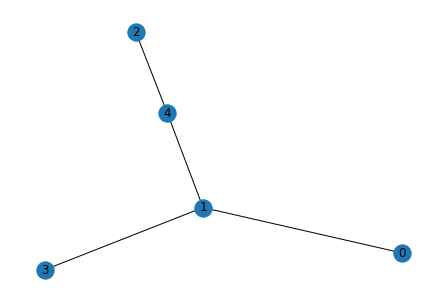

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx


G=nx.Graph()
# Add nodes and edges
for couple in find_connected_sets(points):
    G.add_edge(couple[0], couple[1])

nx.draw(G, with_labels=True)
plt.show()

As already said, we need to determine the order to visit the sets of points. Indeed, in order to translate all the points in a single coordinate system, we can start from a set of points and iteratively transform the other sets into the system of the first set, following their relations in the graph we built. For example, in the example dataset, we can start from 0. From here, we can only visit 1 (since it's the only set which share at least 12 points with 0). From 1, we can either go to 4 or 3. Suppose we go to 3, then there are no other sets left. At this point we visit 4 and finally 2. This procedure corresponds to a Breadth First Search (BFS) visit of the graph of relations.

In [5]:
def get_visit_path(relations, path, visited=None, couple=(-1, 0)):
    couples = [i for i in relations if i[0] == couple[1]]
    for new_couple in couples:
        if new_couple[1] not in visited and new_couple != couple[::-1]:
            path.append(new_couple)
            visited.add(new_couple[1])
            # recursively find next scanners
            get_visit_path(relations, path, visited, couple=new_couple)


path = []
vis = set()
get_visit_path(couples, path, vis)
path

[(0, 1), (1, 3), (1, 4), (4, 2)]

## Find the correct transformation

Up to this point, we didn't describe how to translate a coordinate system to another one given that 2 sets share at least 12 points. We are going to do it next. However, first we need to identify common points between two sets which share at least 12 points. This is a bit boring: I do it by doing some manipulations on the indices in the (symmetric) matrix of pairwise distances. If you're interested in the process, the code is given below:

In [6]:
from scipy.spatial.distance import squareform
from collections import defaultdict, Counter
from itertools import product



def find_shared_points(points_1, points_2):
    pairwise_dist_1 = pdist(points_1, 'sqeuclidean')
    pairwise_dist_2 = pdist(points_2, 'sqeuclidean')
    shared_distances = set(pairwise_dist_1) & set(pairwise_dist_2)
    if len(shared_distances) < 66:
        raise ValueError("At least 12 points are required!")
    dist_1 = squareform(pairwise_dist_1)
    dist_1[np.tril_indices(len(dist_1))] = 0
    dist_2 = squareform(pairwise_dist_2)
    dist_2[np.tril_indices(len(dist_2))] = 0
    graph_dict = defaultdict(Counter)
    for dist in shared_distances:
        first_group = np.where(dist == dist_1)
        second_group = np.where(dist == dist_2)

        for node1 in first_group:
            for node2 in second_group:
                try:
                    graph_dict[node1.item()][node2.item()] += 1
                except ValueError:
                    # if there's more than 1 index from np.where
                    for couple in product(node1, node2):
                        graph_dict[couple[0]][couple[1]] += 1
    graph_dict = {
        node: graph_dict[node].most_common(1)[0][0]
        for node in graph_dict.keys()
        if graph_dict[node].most_common(1)[0][1] >= 11
    }
    return graph_dict



find_shared_points(points[0], points[1])
for key, value in find_shared_points(points[0], points[1]).items():
    print(points[0][key], points[1][value])

[ 528 -643  409] [-460  603 -452]
[-485 -357  347] [ 553  889 -390]
[-661 -816 -575] [729 430 532]
[-345 -311  381] [ 413  935 -424]
[-618 -824 -621] [686 422 578]
[ 404 -588 -901] [-336  658  858]
[ 459 -707  401] [-391  539 -444]
[ 544 -627 -890] [-476  619  847]
[-447 -329  318] [ 515  917 -361]
[ 423 -701  434] [-355  545 -477]
[ 390 -675 -793] [-322  571  750]
[-537 -823 -458] [605 423 415]


Here comes the interesting part! Once we have the shared points, we can actually solve the problem. At this point, we have to find the transformation which transforms one point cloud to the other. This transformation is given by a rotation matrix and a translation vector. If we denote by $x$ and $x'$ the points in the two different coordinate systems, we will have: 

$$ x = R x' + t $$

where $R$ is a $ 3 \times 3 $ rotation matrix and $ t $ is a translation vector. We can actually focus on the rotation matrix, as the translation vector is easy to recover once the points are "aligned".

The problem of finding the rotation matrix can be formalized as an optimization problem. First, we center the point clouds by subtracting them their centroids, i.e., their mean vectors. We define the centered points as $\{y_i\}_{i=1}^n$ and $\{y_i' \}_{i=1}^n$. Then we want to minimize (with respect to the rotation matrix) the sum of the distances between every couple of points. In mathematical terms, we have the following objective to minimize

$$ f(A) = \frac{1}{n} \sum_{i=1}^n \| y_i - A y_i' \| $$

where $A$ belong to the set of real-valued 3 by 3 matrices. 

Is this a convex objective? It easy to verify. Consider the function $g_i(A) = \| y_i - A y_i' \|$. From the definition of convexity:

$$ 
\begin{align}
g_i(\lambda A_1 + (1-\lambda) A_2) &= \| y_i - \lambda A_1  - (1-\lambda) A_2 y_i' \| \\
    &= \| \lambda (y_i - A_1 y_i') + (1-\lambda) (y_i - A_2 y_i') \| \\
    &\leq \lambda \| y_i - A_1 y_i' \| + (1-\lambda) \| y_i - A_2 y_i' \| = \lambda g_i(A_1) + (1-\lambda) g_i(A_2)
\end{align}
$$

where we used the triangle inequality in the third step. Note that $f(A) = \frac{1}{n} \sum_{i=1}^n g_i(A)$ and the sum of convex functions is still a convex function. Hence, we have that $f$ is a convex function and we are guaranteed to find a global optimum.

We didn't specify the norm used in $f$, but it could be any norm. For simplicity, we will consider the Euclidean norm. The correct matrix $R$ will be the one minimizing the objective function $f$,

$$ R = \arg\min_{A \in \mathbb{R}^{3 \times 3}} f(A) $$

To be more precise, the set over which we are minimizing should be the one of the rotation matrices in $3d$ space, i.e., orthogonal matrices 3 by 3 with determinant equal to 1. However, if we use a gradient-based method, this more accurate formulation would involve an expensive projection step on the mentioned set in every step of the optimization process. Also, I found out that the minimization problem above worked well for the task at hand. 

Now that we have our optimization problem formulated, we can try to solve it by using any optimization algorithm. To this aim, we can for example try any of the optimization algorithms contained in pytorch. One nice feature of pytorch is that it computes the gradients automatically, once we define the loss function. Below, we use most famous optimization algorithm, Stochastic Gradient Descent (SGD). The condition we used to determine when to stop the iterations of the optimization algorithm is to consider when the rounded matrix multiplied by the points to be rotated give back the points we want to recover. If this does not happen after 10 thousands steps, an error is raised.

In [7]:
import torch
from functools import partial


def loss_f(x1, x2, model):
    return torch.linalg.norm(x1 - x2 @ model, axis=1).sum() / len(x1)


def optimize(cloud_1, cloud_2, opt_algo, save_history=True):
    centered_cloud_1 = cloud_1 - cloud_1.mean(axis=0)
    centered_cloud_2 = cloud_2 - cloud_2.mean(axis=0)
    centered_cloud_1 = torch.tensor(centered_cloud_1).float()
    centered_cloud_2 = torch.tensor(centered_cloud_2).float()
    history = [centered_cloud_1, centered_cloud_2]
    model = torch.eye(3, requires_grad=True)
    optimizer = opt_algo(params=[model])
    iterations = 10000
    cum_loss = 0
    for step in range(iterations):
        optimizer.zero_grad()
        loss = loss_f(centered_cloud_1, centered_cloud_2, model)
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        converged = torch.all(torch.isclose(centered_cloud_1, centered_cloud_2 @ torch.round(model.detach())))
        if save_history:
            history.append(centered_cloud_2 @ model)
        if converged:
            break

    if not converged:
        raise ValueError(
            f"Method has not converged!\n"
            f"Rotation matrix:\n"
            f"{torch.round(model.detach())}\n"
            f"Loss at step {step}: {loss.item()}"
        )
    rot_mat = np.rint(model.detach().numpy()).astype(int)
    transl_vec = cloud_1[0] - cloud_2[0] @ rot_mat
    return rot_mat, transl_vec, step, history



def find_transf(points_1, points_2, algo, save_history=True):
    # retrieve shared points between point clouds
    graph_dict = find_shared_points(points_1, points_2)
    # retrieve the transformation
    first = points_1[list(graph_dict.keys())]
    second = points_2[list(graph_dict.values())]
    rot_mat, transl_vec, steps, history = optimize(first, second, algo, save_history=save_history)
    return rot_mat, transl_vec, steps, history


We can try to visualize the optimization process, by plotting the the transformed points as the objective function is minimized. We can see that as the optimal solution is approached, the transformed red points approach the original blue points. This only works in an interactive Jupyter notebook though. In the next cell we export the result to an HTML video (see below).

<IPython.core.display.Javascript object>


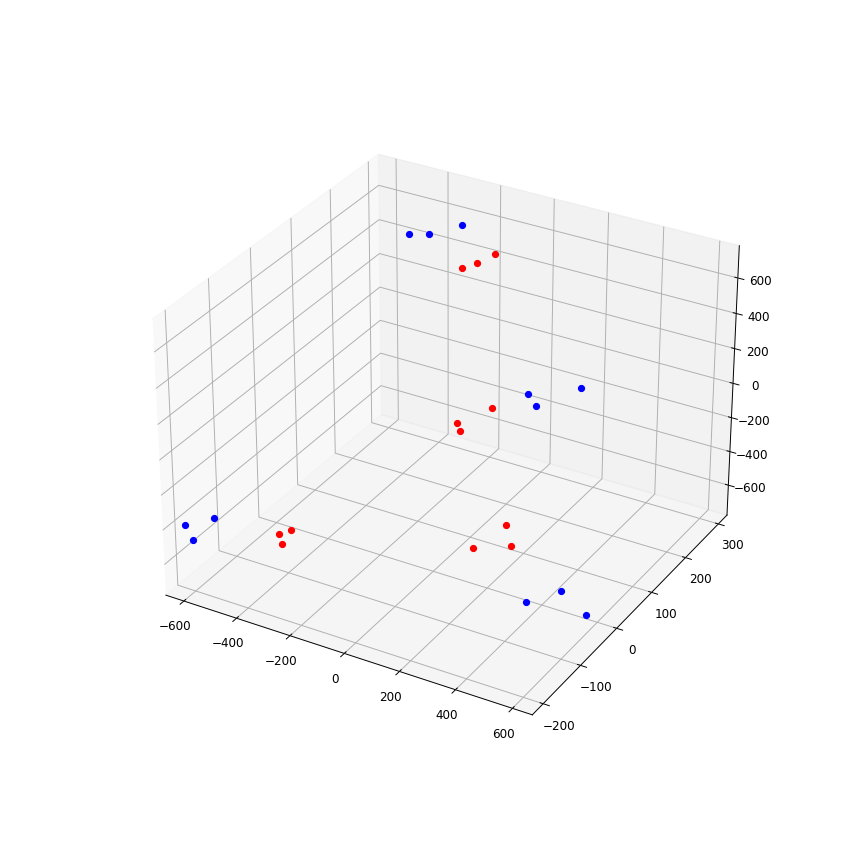

In [8]:
%matplotlib notebook
from IPython.display import HTML
import matplotlib.animation as animation


def update(i, X, Y, Z, cloud1, cloud2):
    cloud2[0].set_data(X[i], Y[i])
    cloud2[0].set_3d_properties(Z[i])
    return cloud1, cloud2


def make_animation(data):
    data = np.array([i.detach().numpy() for i in data])
    xs = data[:, :, 0]
    ys = data[:, :, 1]
    zs = data[:, :, 2]
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, projection='3d')
    cloud_1 = ax.plot(xs[0], ys[0], zs[0], "o", color='blue', markersize=5)
    cloud_2 = ax.plot([], [], [], "o", color='red', markersize=5)

    # ax limits
    x_max = max(xs.flatten())
    x_min = min(xs.flatten())
    y_max = max(ys.flatten())
    y_min = min(ys.flatten())
    z_max = max(zs.flatten())
    z_min = min(zs.flatten())
    ax.set_xlim(x_min - 10, x_max + 10)
    ax.set_ylim(y_min - 10, y_max + 10)
    ax.set_zlim(z_min - 10, z_max + 10)

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(data) - 1,
        fargs=(xs, ys, zs, cloud_1, cloud_2),
        interval=100,
        blit=True,
        repeat=True,
    )
    # ani.save('rotation.gif', writer='imagemagick', fps=200)
    return ani


sgd = partial(torch.optim.SGD, lr=1e-4)
_, _, _, hist = find_transf(points[0], points[1], sgd)
ani = make_animation(hist)

In [9]:
HTML(ani.to_html5_video())

One disadvantage of SGD is that it has a learning rate to be set, which can influence the speed of convergence of the optimization process. Even more bad, if the learning rate is completely wrong, the solution will never converge to the optimal one (for example, you can [download the notebook](https://nicolaus93.github.io/assets/aoc19.ipynb) and try to use lr=1e-2)! For this reason, finding a good learning rate is a time consuming process, since different values have to be tried until a good one is found. On the other hand, there are also other optimization algorithms which do not need parameters such as the learning rate to be tuned and can still converge to the optimal solution. One such algorithm is Cocob, which has been used also to train neural networks. Let's see how it performs on this problem.

In [10]:
%%capture
from optimal_pytorch.coin_betting.torch import Cocob

_, _, _, hist = find_transf(points[0], points[1], Cocob)
ani = make_animation(hist)

Note how we don't have to set any $lr$ parameter above!

In [11]:
HTML(ani.to_html5_video())

There's also another subtle difference which can be noticed by looking at the videos above. If you look at the speed of the moving points when using SGD and Cocob, you can see that it is not the same. In SGD it is constant, and the red points slowly approach the blue ones. On the other hand, with Cocob the red points start moving slowly but then their speed greatly increases as they approach the blue ones. What is going on here?

The explanation is that the learning rate in SGD is fixed (at least in the pytorch version), while in Cocob it is not! But.. Didn't we say the Cocob does not have any learning rate? Well, Cocob doesn't have any learning rate to be **set**, but that doesn't mean it has no learning rate at all. The truth is that this algorithm is able to determine automatically the optimal learning rate, which is not fixed in advance, but changes depending on the data fed to it. In particular, it can be shown that finding the optimal learning rate is more or less equivalent to betting on the outcome of a coin in a game where the goal of the algorithm is to increase its total amount of money, hence the name Cocob (which stands for Continuous **Coin Betting**). Furthermore, if the objective function is fixed, the amount of money which is the algorithm is betting on (which is equivalent to learning rate) will grow exponentially and the algorithm will approach the optimal solution exponentially fast! If you're interested in a more detailed explanation you can watch [this video](https://youtu.be/f4KTZoClfs4?t=948). Coin betting is a fascinating and theoretically grounded area of research in optimization!

## Solving the original problem

Now that we have all the pieces needed, we can solve the original problem! In particular, there are 2 tasks:

- Translate all the points to a single coordinate system and count the number of unique points
- Find the couple of scanners which are at the largest Manhattan distance apart. What is such distance?

Below, we show how to use the functions described until now to solve the 2 tasks:

In [12]:
def solve(data_file, algo, save_iterations=False):
    point_clouds = read_input(data_file)
    couples = find_connected_sets(point_clouds)
    visit_path = []
    vis = set()
    get_visit_path(couples, visit_path, vis)  # modify path inplace
    transl_vectors = []
    tot_iterations = 0
    for couple in visit_path:
        first, second = couple
        rot_mat, transl_vec, iterations, history = find_transf(
            point_clouds[first], 
            point_clouds[second], 
            algo, 
            save_history=save_iterations
        )
        point_clouds[second] = point_clouds[second] @ rot_mat + transl_vec
        transl_vectors.append(transl_vec)
        tot_iterations += len(history) - 1
    
    common_points = set()
    for cloud in point_clouds:
        for point in cloud:
            common_points.add(tuple(point))
        
    max_dist = max(pdist(transl_vectors, 'cityblock'))
    if save_iterations:
        print(f"Total number of iterations: {tot_iterations}")
    return len(common_points), int(max_dist)
    
    
part_1, part_2 = solve("test.txt", Cocob)
print(f"part1: {part_1}")
print(f"part2: {part_2}")

part1: 79
part2: 3621


In [13]:
part_1, part_2 = solve("test.txt", partial(torch.optim.SGD, lr=1e-4))
print(f"part1: {part_1}")
print(f"part2: {part_2}")

part1: 79
part2: 3621


And now the real puzzle, both with Cocob and SGD:

In [14]:
part_1, part_2 = solve("input_puzzle.txt", Cocob)
print(f"part1: {part_1}")
print(f"part2: {part_2}")

part1: 400
part2: 12168


In [15]:
part_1, part_2 = solve("input_puzzle.txt", partial(torch.optim.SGD, lr=1e-4))
print(f"part1: {part_1}")
print(f"part2: {part_2}")

part1: 400
part2: 12168


We can also measure how long it takes for the optimization algorithms to find the solution in terms of time:

In [16]:
%%timeit
solve("input_puzzle.txt", Cocob)

508 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
solve("input_puzzle.txt", partial(torch.optim.SGD, lr=1e-4))

958 ms ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It seems that Cocob is faster. However, the time taken to find a solution is not really meaningful since it is subject to many different variables. Instead, we can measure how many iterations the algorithms need:

In [18]:
solve("input_puzzle.txt", Cocob, save_iterations=True)

Total number of iterations: 2069


(400, 12168)

In [19]:
solve("input_puzzle.txt", partial(torch.optim.SGD, lr=1e-4), save_iterations=True)

Total number of iterations: 4936


(400, 12168)

## Summary

This was definitely a cool problem to solve in this year's Advent of Code! I hope you enjoyed the explanation on optimization algorithms and especially **coin betting**. I didn't go into much detail, but if you're interested this is a very nice topic in optimization and machine learning. You can find many resources online, and there even was a [tutorial](https://www.youtube.com/watch?v=UT_ziU3nIwU&t=619s) at last year's ICML. Despite their [practical success](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md#training-and-validation), I believe these algorithms are still not very well known to the practicioners. One of the reason is that there are not many implementations available. For this reason, last year we started implementing some of them in pytorch, and currently a [library](https://github.com/Nicolaus93/coin_betting) on Github is available on my profile. The plan is to add more parameter-free algorithms to the library (not only in torch but also JAX) and extensively test them against other more famous optimization algorithms such as SGD or Adam.